# GOES from S3 on AWS

Original [example](https://github.com/HamedAlemo/visualize-goes16) by Hamed Alemo demonstrating [GOES on AWS](https://registry.opendata.aws/noaa-goes/).

In [1]:
import xarray as xr
import requests
import netCDF4
import boto3
from botocore import UNSIGNED
from botocore.config import Config

import re

In [2]:
# import pystare as ps

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cf

import numpy
import shapely

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import geopandas

In [3]:
# Some helper functions for plotting & printing.

class figax_container(object):
    def __init__(self,figax):
        self.fig = figax[0]
        self.ax  = figax[1]
        return

def add_coastlines(figax,set_global=False):
    "Add coastlines to the plot."
    ax = figax.ax
    if set_global:
        ax.set_global()
    ax.coastlines()
    return figax

def hello_plot(
        spatial_index_values=None
        ,figax=None
        ,plot_options={'projection':ccrs.PlateCarree(),'transform':ccrs.Geo
                       
                       detic()}
        ,set_global=False
        ,set_coastlines=True
        ,show=True
        ,color=None
        ,lw=1
        ):

    if figax is None:
        figax = figax_container(plt.subplots(1,subplot_kw=plot_options))
        if set_global:
            figax.ax.set_global()
        if set_coastlines:
            figax.ax.coastlines()
    else:
        ax = figax.ax
    
    if spatial_index_values is not None:
        # Calculate vertices and interconnection matrix
        lons,lats,intmat = ps.triangulate_indices(spatial_index_values)
        
        # Make triangulation object & plot
        siv_triang = tri.Triangulation(lons,lats,intmat)
        figax.ax.triplot(siv_triang,c=color,transform=plot_options['transform'],lw=lw)
    
    if show:
        plt.show()
        
    return figax

def hex16(i):
    return "0x%016x"%i

def lonlat_from_coords(coords):
    tmp = numpy.array(coords)
    lat=tmp[:,1]
    lon=tmp[:,0]
    return lon,lat

km  = 1 # Unit of length
deg = 1 # Unit of angle

In [4]:
# Set up the projection and transformation
proj         = ccrs.PlateCarree()
# proj        = ccrs.Robinson() # Drives matplotlib bug.
# proj        = ccrs.Mollweide() # Drives matplotlib bug.
transf       = ccrs.Geodetic()
plot_options = {'projection':proj,'transform':transf}

default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = 1.5*default_dpi

In [5]:
# !uptime
# !aws help


In [51]:
bucket_name = 'noaa-goes16'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 79
hour = 10
band = 3
search_prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M3C{band:02.0f}'

In [53]:
bucket_name = 'noaa-goes17'
product_name = 'ABI-L1b-RadF'
year = 2019
day_of_year = 336
hour = 19
band = 3
search_prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6C{band:02.0f}'

In [7]:
bucket_name = 'noaa-goes17'
product_name = 'ABI-L2-TPWF'
year = 2019
day_of_year = 356
hour = 19
search_prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6'

In [4]:
def make_s3_client(credentials='/home/jovyan/.aws/credentials'):
    "Initialize s3 client."
    rhs = re.compile('^.* = (.*)$')
    with open(credentials) as c:
        dmy    = c.readline()
        key    = rhs.match(c.readline()).group(1)
        secret = rhs.match(c.readline()).group(1)
    return boto3.client('s3'
                        ,aws_access_key_id     = key
                        ,aws_secret_access_key = secret)

# s3_client = make_s3_client()

s3_client = boto3.client('s3',config=Config(signature_version=UNSIGNED))

In [5]:
def get_s3_keys(bucket, s3_client, prefix = '', nmax = 10):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        try:
            for obj in resp['Contents']:
                key = obj['Key']
                if key.startswith(prefix):
                    yield key
        except KeyError:
            print('Empty response from s3 for bucket %s with prefix %s'%(bucket,prefix))
            break

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

In [8]:
print('searching for: %s in bucket %s'%(search_prefix,bucket_name))
keys = get_s3_keys(bucket_name,
                    s3_client,
                    prefix = search_prefix
                  )

key_list = [key for key in keys] # selecting the first measurement taken within the hour
key = key_list[2]
print('loading: ',key)

searching for: ABI-L2-TPWF/2019/356/19/OR_ABI-L2-TPWF-M6 in bucket noaa-goes17
loading:  ABI-L2-TPWF/2019/356/19/OR_ABI-L2-TPWF-M6_G17_s20193561920332_e20193561929399_c20193561930257.nc


In [9]:
resp = requests.get(f'https://{bucket_name}.s3.amazonaws.com/{key}')

In [10]:
file_name = key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)

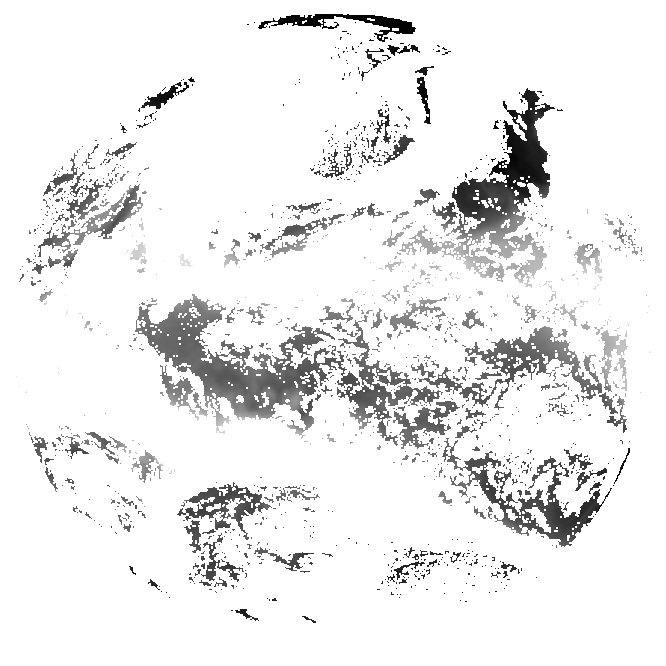

In [16]:
fig = plt.figure(figsize=(12, 12))
plt.imshow(DS.TPW, cmap='gray')
plt.axis('off')
plt.savefig(f'{file_name}.png', dpi=300, facecolor='w', edgecolor='w')

In [12]:
nc4_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    naming_authority: gov.nesdis.noaa
    Conventions: CF-1.7
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    standard_name_vocabulary: CF Standard Name Table (v35, 20 July 2016)
    institution: DOC/NOAA/NESDIS > U.S. Department of Commerce, National Oceanic and Atmospheric Administration, National Environmental Satellite, Data, and Information Services
    project: GOES
    production_site: NSOF
    production_environment: OE
    spatial_resolution: 10km at nadir
    orbital_slot: GOES-West
    platform_ID: G17
    instrument_type: GOES R Series Advanced Baseline Imager
    scene_id: Full Disk
    instrument_ID: FM2
    dataset_name: OR_ABI-L2-TPWF-M6_G17_s20193561920332_e20193561929399_c20193561930257.nc
    iso_series_metadata_id: 42511480-afef-11e1-afa6-0800200c9a66
    title: ABI L2 Total Precipitable Water
    summary: The Total Precipitable Water product consists of the water dept

In [32]:
print(nc4_ds['geospatial_lat_lon_extent'])
print()
print(nc4_ds['goes_imager_projection'])

<class 'netCDF4._netCDF4.Variable'>
float32 geospatial_lat_lon_extent()
    long_name: geospatial latitude and longitude references
    geospatial_westbound_longitude: 141.7005
    geospatial_northbound_latitude: 81.3282
    geospatial_eastbound_longitude: -55.7005
    geospatial_southbound_latitude: -81.3282
    geospatial_lat_center: 0.0
    geospatial_lon_center: -137.0
    geospatial_lat_nadir: 0.0
    geospatial_lon_nadir: -137.0
    geospatial_lat_units: degrees_north
    geospatial_lon_units: degrees_east
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used

<class 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -137.0
 